In [1]:
import numpy as np
import kaldiio
from kaldiio import ReadHelper
import seaborn as sns
import os
import random
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import torch
import torch.utils.data as data
import torch.nn.utils.rnn as rnn_utils
import torch.nn as nn

from scipy.interpolate import make_interp_spline
from scipy import stats
import pandas as pd
from tqdm import tqdm

In [2]:
from Define_Model.ResNet import ThinResNet
from Define_Model.Loss.SoftmaxLoss import AdditiveMarginLinear
from Process_Data.audio_processing import read_WaveInt

In [3]:
script_dir = '/home/yangwenhao/local/project/SpeakerVerification-pytorch'
lstm_dir = '/home/yangwenhao/local/project/lstm_speaker_verification'

kwargs = {'num_workers': 8, 'pin_memory': False}
checkpoint_path = script_dir + '/Data/checkpoint/ThinResNet18/Mean_batch256_basic_downk3_avg0_SAP2_em256_dp01_alpha0_none1_wde4_esmix2/arcsoft_sgd_rop/vox1/wave_fb40_dist2/123456'

In [4]:
dataset = 'vox1'
uid2path  = {}
with open(lstm_dir + '/data/%s/dev/wav.scp' % (dataset), 'r') as f:
    for l in f.readlines():
        uid, upath = l.split()
        uid2path[uid] = upath

sid2utt  = {} 
with open(lstm_dir + '/data/%s/dev/spk2utt' % (dataset), 'r') as f:
    for l in f.readlines():
        s_lst = l.split()
        sid2utt[s_lst[0]] = s_lst[1:]

spks = list(sid2utt.keys())
random.shuffle(spks)
numofspk = 10
numofutt = 100
target_spks = spks[:numofspk]

all_data = []
for s in target_spks:
    for u in sid2utt[s][:numofutt]:
        path = uid2path[u]
        all_data.append([u, read_WaveInt(path)])

In [5]:
sid2idx = {s:i for i,s in enumerate(target_spks)}

In [ ]:
model = ThinResNet(resnet_size=18, num_classes=1211, 
                 input_norm='Mean', input_len=300, input_dim=40, 
                 filter='fbank', feat_dim=40, sr=16000, stretch_ratio=[1.0], win_length=int(0.025*16000),
                 nfft=512, kernel_size=5, stride=[2,1], padding=2, first_bias=True, 
                 block_type='basic', expansion=1, channels=[16, 32, 64, 128], fast='none1', downsample='k3', 
                 dropout_p=0.1, 
                 encoder_type='SAP2', time_dim=1, avg_size=0, embedding_size=256, 
                 alpha=0,
                 mask='None', mask_len=[5, 10], init_weight='mel', scale=0.2, weight_p=0.1, weight_norm='max',
                 mix='mixup',)
model.classifier = AdditiveMarginLinear(feat_dim=256, num_classes=1211)
model = model.cuda()
model.eval()

In [6]:
model.input_mask[0].t.mel_scale.fb.shape

torch.Size([257, 40])

In [9]:
all_vectors = {}
for epoch in tqdm(range(1, 45)):
    vectors = []
    checkpoint = checkpoint_path +'/checkpoint_%d.pth'%epoch
    if not os.path.exists(checkpoint):
        continue
        
    model.load_state_dict(torch.load(checkpoint)['state_dict'])
    # model.eval()
    for u, x in all_data:
        data = torch.tensor(x).cuda().reshape(1,1,1,-1)
        _, embededings = model(data)
        vectors.append([u, embededings.detach().cpu().numpy()[0]])
    
    all_vectors[epoch] = vectors

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [02:04<00:00,  2.83s/it]


In [10]:
epochs = list(all_vectors.keys())
epochs.sort()

labels = np.array([sid2idx[u.split('-')[0]] for u,_ in all_vectors[1]])

In [11]:
indexs = [np.where(labels==i)[0].min() for i in range(10)]
indexs.append(len(labels))

In [12]:
epoch_embeds = []

for e in epochs:
    embeds = [em for u, em in all_vectors[e]:]
    embeds = np.array(embeds)
    epoch_embeds.append(embeds)

epoch_embeds = np.array(epoch_embeds)
print(epoch_embeds.shape)

speaker_prototype = []
for i in range(1, len(indexs)):
    prototype = epoch_embeds[:, indexs[i-1]:indexs[i], :].mean(axis=1)
    # print(prototype.shape)
    speaker_prototype.append(prototype)
    
speaker_prototype = torch.tensor(np.array(speaker_prototype))
print(speaker_prototype.shape)

(44, 863, 256)
torch.Size([10, 44, 256])


In [19]:
dist = torch.nn.CosineSimilarity(dim=-1)

relative_dists = dist(speaker_prototype[:, 1:], speaker_prototype[:, :-1]).mean(dim=0)
abs_dists = dist(speaker_prototype[:, :-1], speaker_prototype[:, -1].unsqueeze(1).repeat(1,43,1)).mean(dim=0)

In [48]:
dists.shape

torch.Size([17])

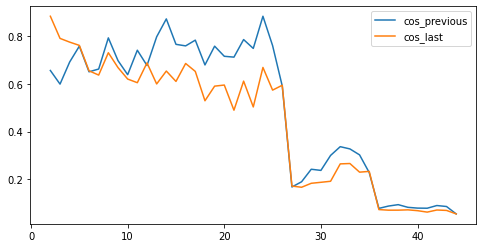

In [23]:
plt.figure(figsize=(8, 4))

plt.plot(epochs[1:], dists.arccos())
plt.plot(epochs[1:], abs_dists.arccos())
plt.legend(['previous', 'last'])

In [88]:
2 % 1

0